In [1]:
# Import required libraries
import io
import pandas as pd
from google.colab import files

# Upload the CSV file
uploaded = files.upload()

# Load the uploaded file into a pandas DataFrame
ev_data = pd.read_csv(io.BytesIO(uploaded['ev-charging-stations-india.csv']))

# Display the first few rows of the dataset to understand its structure
ev_data.head()

Saving ev-charging-stations-india.csv to ev-charging-stations-india.csv


,name,state,city,address,lattitude,longitude,type
0,Neelkanth Star DC Charging Station,Haryana,Gurugram,"Neelkanth Star Karnal, NH 44, Gharunda, Kutail...",29.6019,76.9803,12.0
1,Galleria DC Charging Station,Haryana,Gurugram,"DLF Phase IV, Sector 28, Gurugram, Haryana 122022",28.4673,77.0818,12.0
2,Highway Xpress (Jaipur-Delhi) DC charging station,Rajasthan,Behror,"Jaipur to Delhi Road, Behror Midway, Behror, R...",27.8751,76.2760,12.0
3,Food Carnival DC Charging Station,Uttar Pradesh,Khatauli,"Fun and Food Carnival, NH 58, Khatauli Bypass,...",29.3105,77.7218,12.0
4,Food Carnival AC Charging Station,Uttar Pradesh,Khatauli,"NH 58, Khatauli Bypass, Bhainsi, Uttar Pradesh...",29.3105,77.7218,12.0


In [2]:
# Convert 'lattitude' to numeric and fix the spelling, drop the old column
ev_data['latitude'] = pd.to_numeric(ev_data['lattitude'], errors='coerce')
ev_data.drop('lattitude', axis=1, inplace=True)

# Convert 'longitude' to numeric
ev_data['longitude'] = pd.to_numeric(ev_data['longitude'], errors='coerce')

# Fill missing 'address' values with 'Unknown'
ev_data['address'].fillna('Unknown', inplace=True)

# Fill missing 'type' values with the most common type
ev_data['type'].fillna(ev_data['type'].mode()[0], inplace=True)

# Check for remaining missing values
ev_data.isnull().sum()

,0
name,0
state,0
city,0
address,0
longitude,6
type,0
latitude,8


In [3]:
# Grouping by state to get the number of stations in each state
state_group = ev_data.groupby('state').size().reset_index(name='stations_count')

# Grouping by city to get the number of stations in each city
city_group = ev_data.groupby('city').size().reset_index(name='stations_count')

# Grouping by charging type to get the number of stations by type
type_group = ev_data.groupby('type').size().reset_index(name='stations_count')

# Display the segmentation results
state_group.head(), city_group.head(), type_group.head()


(             state  stations_count
 0          Andaman               1
 1   Andhra Pradesh              31
 2  Andhra Pradesh                1
 3   Andhra pradesh              24
 4    AndhraPradesh               1,
         city  stations_count
 0  AHMEDABAD               2
 1      ATTUR               2
 2   AVINASHI               2
 3   Adilabad               1
 4      Adoor               1,
    type  stations_count
 0   6.0             305
 1   7.0             689
 2   8.0             135
 3  10.0              10
 4  11.0              65)

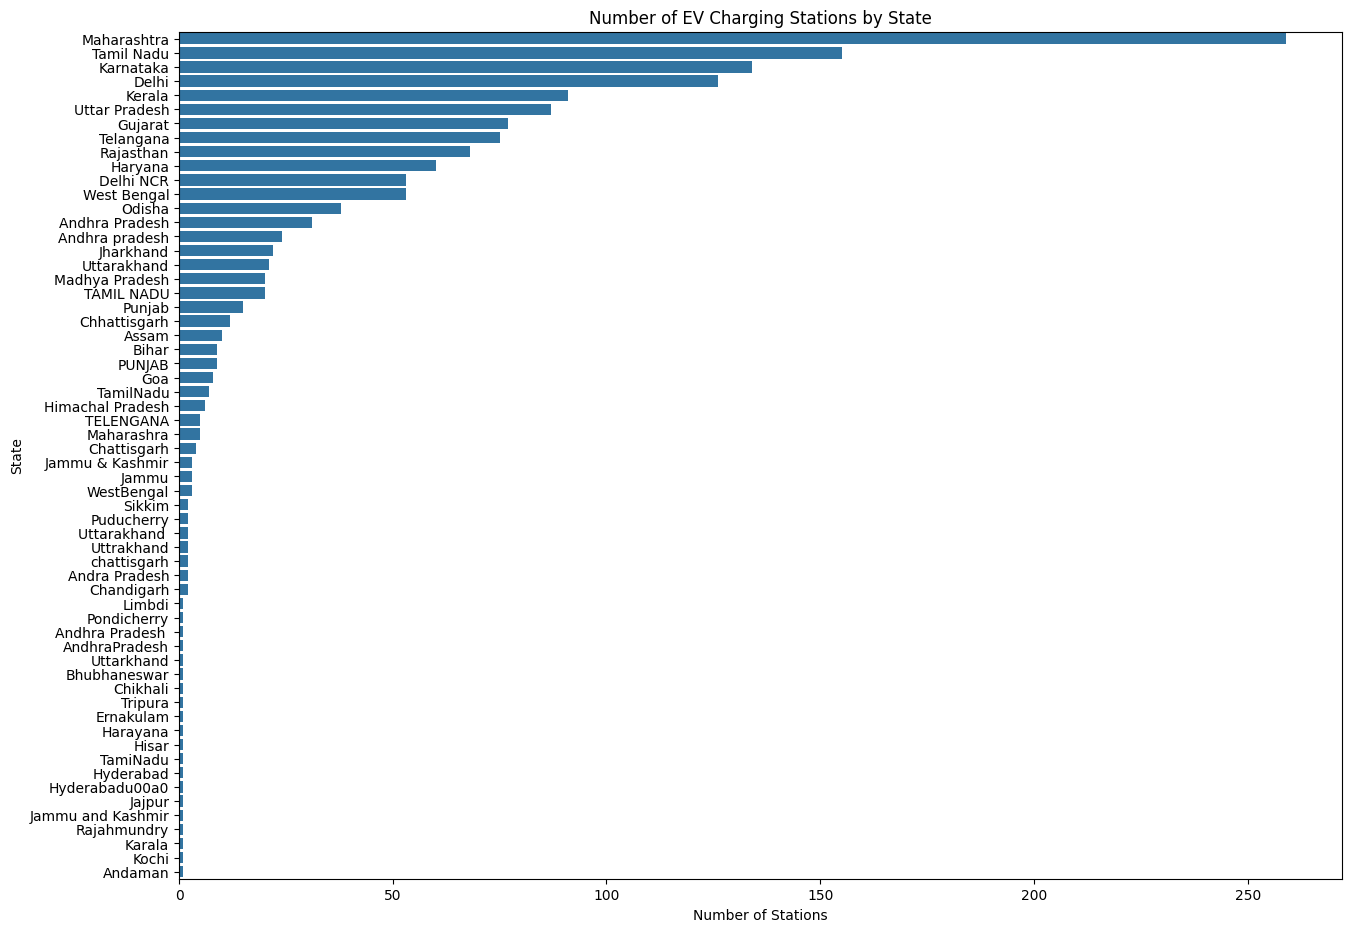

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot showing the number of charging stations in each state
plt.figure(figsize=(15, 11))
sns.barplot(x='stations_count', y='state', data=state_group.sort_values(by='stations_count', ascending=False))
plt.title('Number of EV Charging Stations by State')
plt.xlabel('Number of Stations')
plt.ylabel('State')
plt.show()

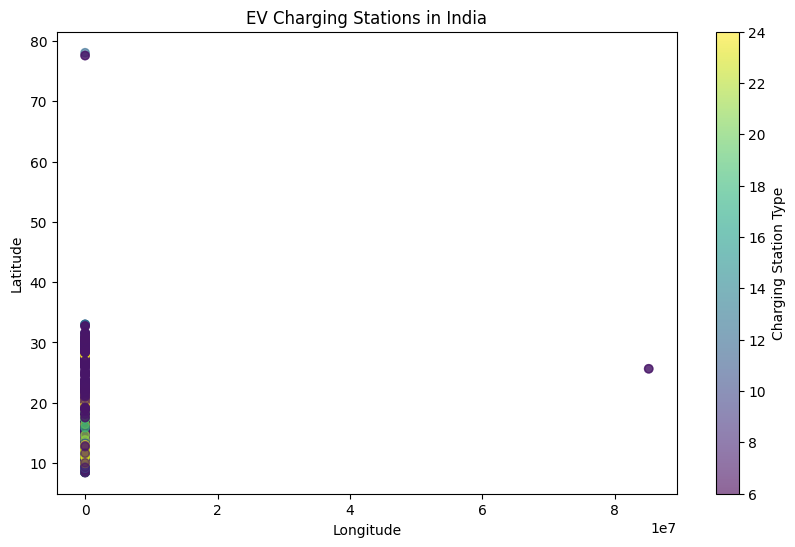

In [5]:
# Scatter plot of EV charging stations based on their geographical coordinates
plt.figure(figsize=(10, 6))
plt.scatter(ev_data['longitude'], ev_data['latitude'], c=ev_data['type'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Charging Station Type')
plt.title('EV Charging Stations in India')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

       latitude  longitude
0     29.601900  76.980300
1     28.467300  77.081800
2     27.875100  76.276000
3     29.310500  77.721800
4     29.310500  77.721800
...         ...        ...
1542  10.029793  77.045859
1543  28.390459  76.959200
1544  28.411072  77.040546
1545  32.706412  74.879203
1546  12.885716  74.843476

[1539 rows x 2 columns]


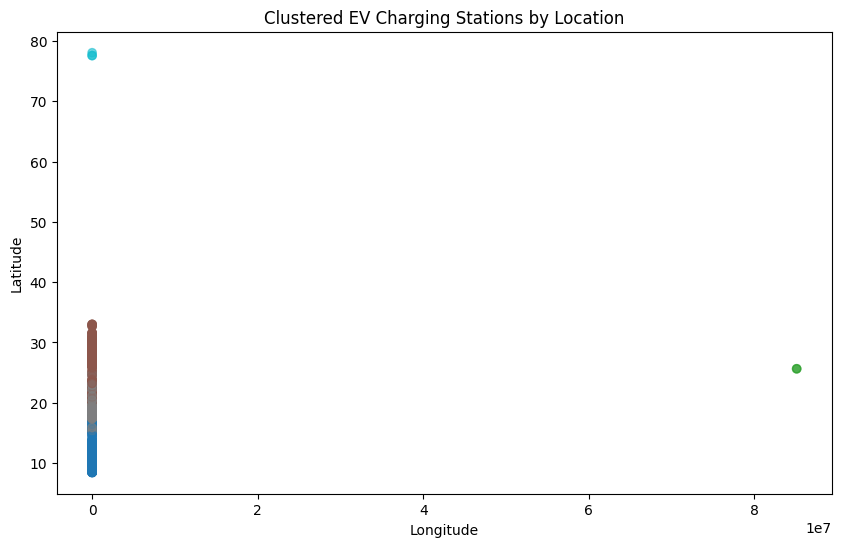

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Dropping rows with missing latitude or longitude values
X = ev_data[['latitude', 'longitude']].dropna()
print(X)

# Performing KMeans clustering on the geographical coordinates
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

# Create a new column 'cluster' in the original DataFrame, aligning indices
ev_data.loc[X.index, 'cluster'] = kmeans.predict(X)

# Visualizing the clusters on a map
plt.figure(figsize=(10, 6))
plt.scatter(X['longitude'], X['latitude'], c=ev_data.loc[X.index, 'cluster'], cmap='tab10', alpha=0.6)
plt.title('Clustered EV Charging Stations by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [7]:
# Check for missing values in latitude and longitude
print(ev_data[['latitude', 'longitude']].isnull().sum())

# Drop rows with missing values in latitude or longitude
ev_data_clean = ev_data[['latitude', 'longitude']].dropna()

# Verify the cleaned data
print(ev_data_clean.isnull().sum())
print(ev_data_clean.shape)  # Check the shape of the cleaned data


latitude     8
longitude    6
dtype: int64
latitude     0
longitude    0
dtype: int64
(1539, 2)


In [8]:
# Check the data types of latitude and longitude
print(ev_data.dtypes)

# Convert to numeric again, just to be sure
ev_data['latitude'] = pd.to_numeric(ev_data['latitude'], errors='coerce')
ev_data['longitude'] = pd.to_numeric(ev_data['longitude'], errors='coerce')

# Check if the conversion worked
print(ev_data[['latitude', 'longitude']].dtypes)


name          object
state         object
city          object
address       object
longitude    float64
type         float64
latitude     float64
cluster      float64
dtype: object
latitude     float64
longitude    float64
dtype: object


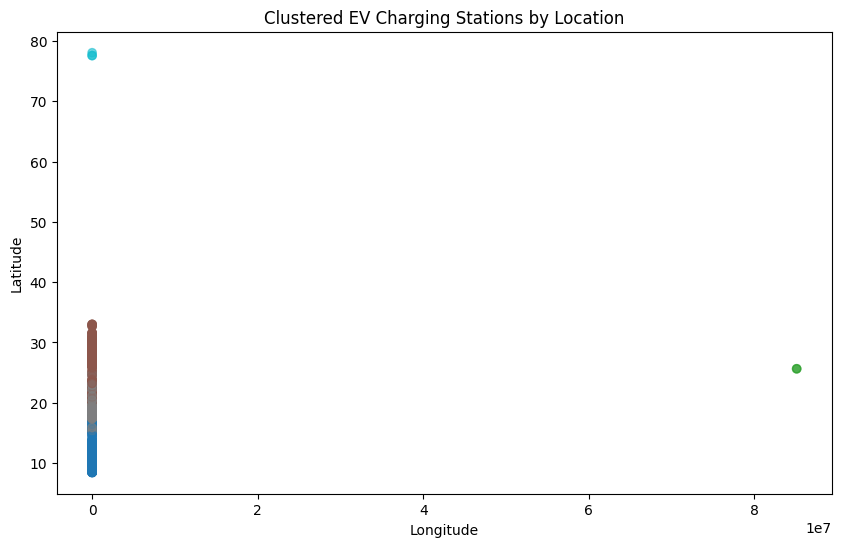

In [9]:
from sklearn.cluster import KMeans

# Ensure you're using the cleaned data
X = ev_data_clean

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

# Assign clusters back to the original DataFrame (only for the non-missing rows)
ev_data.loc[ev_data_clean.index, 'cluster'] = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X['longitude'], X['latitude'], c=kmeans.labels_, cmap='tab10', alpha=0.6)
plt.title('Clustered EV Charging Stations by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [10]:
# Insight 1: State with the highest number of stations
most_stations_state = state_group.sort_values(by='stations_count', ascending=False).iloc[0]
print(f"The state with the most charging stations is {most_stations_state['state']} with {most_stations_state['stations_count']} stations.")

# Insight 2: City with the highest number of stations
most_stations_city = city_group.sort_values(by='stations_count', ascending=False).iloc[0]
print(f"The city with the most charging stations is {most_stations_city['city']} with {most_stations_city['stations_count']} stations.")

# Insight 3: Most common type of charging station
most_common_type = type_group.sort_values(by='stations_count', ascending=False).iloc[0]
print(f"The most common type of charging station is type {most_common_type['type']} with {most_common_type['stations_count']} stations.")

# Conclusion: Summary of overall findings

The state with the most charging stations is Maharashtra with 259 stations.
The city with the most charging stations is Delhi with 72 stations.
The most common type of charging station is type 7.0 with 689.0 stations.
